# 주간 버스 승차총승객수

## 1. 데이터 전처리

In [6]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pyspark.sql.types as T
import pyspark.sql.functions as F
import pandas as pd
import numpy as np

In [29]:
df = pd.read_parquet('bus_main.parquet')
df

,사용일자,일별이용자수
0,2018-01-01,2526585
1,2018-01-02,5401907
2,2018-01-03,5570015
3,2018-01-04,5547362
4,2018-01-05,5741154
...,...,...
1391,2021-10-27,4745936
1392,2021-10-28,4722851
1393,2021-10-29,4801950
1394,2021-10-30,3523511


In [30]:
#데이터 타입 확인
df.dtypes

사용일자      object
일별이용자수     int64
dtype: object

In [31]:
#사용일자 컬럼을 데이터 타입을 datetime으로 변경
df['사용일자'] = pd.to_datetime(df['사용일자'])

In [33]:
#데이터 타입 변경됐는지 확인
df.dtypes

사용일자      datetime64[ns]
일별이용자수             int64
dtype: object

In [34]:
#사용일자 컬럼을 일별에서 주별로 나누어 변환함.
weekly_df = df.resample('w', on='사용일자').일별이용자수.sum().reset_index()
weekly_df

,사용일자,일별이용자수
0,2018-01-07,32127777
1,2018-01-14,34827241
2,2018-01-21,36112393
3,2018-01-28,33451739
4,2018-02-04,35701402
...,...,...
195,2021-10-03,28887061
196,2021-10-10,26639266
197,2021-10-17,27426874
198,2021-10-24,29150432


In [37]:
#일요일날로 기준이되어있어서 가시성을 주기위해 월요일 기준으로 바꿈
from datetime import datetime, timedelta
weekly_df["사용일자"] = weekly_df['사용일자'] - timedelta(days=6)
weekly_df

,사용일자,일별이용자수
0,2018-01-01,32127777
1,2018-01-08,34827241
2,2018-01-15,36112393
3,2018-01-22,33451739
4,2018-01-29,35701402
...,...,...
195,2021-09-27,28887061
196,2021-10-04,26639266
197,2021-10-11,27426874
198,2021-10-18,29150432


In [47]:
#일별 이용자수 컬럼을 변경
weekly_df = weekly_df.rename(columns={"일별이용자수" : "주별이용자수"})
weekly_df

,사용일자,주별이용자수
0,2018-01-01,32127777
1,2018-01-08,34827241
2,2018-01-15,36112393
3,2018-01-22,33451739
4,2018-01-29,35701402
...,...,...
195,2021-09-27,28887061
196,2021-10-04,26639266
197,2021-10-11,27426874
198,2021-10-18,29150432


In [48]:
#parqeut 저장 시 사용일자에 시간이 뜨는 오류가 생겨서 string으로 데이터타입 변환
weekly_df = weekly_df.astype({"사용일자" : 'str'})
weekly_df.dtypes

사용일자      object
주별이용자수     int64
dtype: object

In [49]:
#parquet 저장
weekly_df.to_parquet("bus_per_week.parquet")

In [50]:
#parquet 파일 확인
pq = spark.read.parquet('bus_per_week.parquet')
pq.show()

+----------+------------+-----------------+
|  사용일자|주별이용자수|__index_level_0__|
+----------+------------+-----------------+
|2018-01-01|    32127777|                0|
|2018-01-08|    34827241|                1|
|2018-01-15|    36112393|                2|
|2018-01-22|    33451739|                3|
|2018-01-29|    35701402|                4|
|2018-02-05|    36128143|                5|
|2018-02-12|    26482273|                6|
|2018-02-19|    36183504|                7|
|2018-02-26|    34159102|                8|
|2018-03-05|    38058058|                9|
|2018-03-12|    38116458|               10|
|2018-03-19|    37936129|               11|
|2018-03-26|    38401242|               12|
|2018-04-02|    37805778|               13|
|2018-04-09|    37832180|               14|
|2018-04-16|    37607457|               15|
|2018-04-23|    37818882|               16|
|2018-04-30|    34235778|               17|
|2018-05-07|    31767297|               18|
|2018-05-14|    38189811|               19

## 2. 그래프 확인

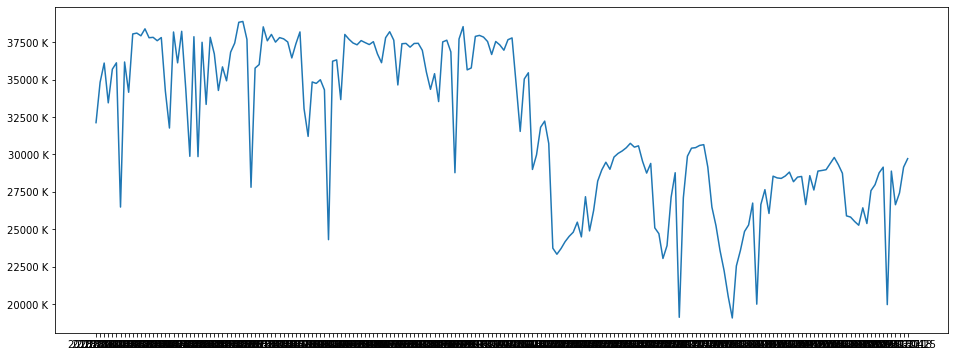

In [51]:
#그래프 예시
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(16,6))
plt.plot(weekly_df['사용일자'], weekly_df['주별이용자수']/1000)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i K'))
plt.show()

In [53]:
df2= pd.read_parquet('bus_per_week.parquet')
df2

,사용일자,주별이용자수
0,2018-01-01,32127777
1,2018-01-08,34827241
2,2018-01-15,36112393
3,2018-01-22,33451739
4,2018-01-29,35701402
...,...,...
195,2021-09-27,28887061
196,2021-10-04,26639266
197,2021-10-11,27426874
198,2021-10-18,29150432


In [62]:
#날짜 확인
df2[df2["주별이용자수"] < 22500000].head(50)

,사용일자,주별이용자수
143,2020-09-28,19109563
154,2020-12-14,22219093
155,2020-12-21,20500332
156,2020-12-28,19064812
162,2021-02-08,19987733
194,2021-09-20,19958551
